In [205]:
''' Imports '''
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from scipy.linalg import norm, pinv
from scipy import fft

ttype = torch.float32
device = torch.device('cpu')

In [206]:
''' ISTA Functions '''
def relu(x):
    return x * (x > 0)
def soft_threshold(x, t):
    return np.sign(x) * relu(np.abs(x) - t)
def ista(A, b, l=1, maxit=50):
    M, N = A.shape
    #x = np.zeros([N, 1])
    # initialize with pseudo-inverse solution
    x = pinv(A) @ b
    L = norm(A) ** 2
    AHA = A.conj().T @ A
    AH = A.conj().T
    for _ in range(maxit):
        x = soft_threshold(x - (1/L * AHA @ x) + (1/L * AH @ b) , l / L)
    return x

In [207]:
''' LISTA Functions'''
class sparse_dataset(Dataset):
    def __init__(self, N, K, Nexamples):
        self.X = np.zeros((Nexamples, N, 1))
        for ii in range(Nexamples):
            self.X[ii,...] = self.generate_sparse_vector(N, K)
        self.X *= np.random.randn(*self.X.shape)
        self.X = torch.from_numpy(self.X)
    
    def __getitem__(self, i):
        return self.X[i, ...]
    
    def __len__(self, ):
        return self.X.shape[0]
    
    def generate_sparse_vector(self, N, K):
        x = np.zeros((N,1))
        x[:K,...] = 1.
        np.random.shuffle(x)
        return x
    
def Aop(A, x):
    return torch.matmul(A,x)

def softthr(x, thr):
    z = torch.abs(x) - thr
    z = z * torch.sign(x) * torch.max(torch.abs(x), thr)
    return z

def pbnet(A, alpha, lamb, x0, xt, K, testFlag=True, explicit_grad=True):
    # pbnet - Physics-based Network
    # args in - 
    #   A - measurement matrix
    #   alpha - step size
    #   lamb - sparsity penalty
    #   x0 - initialization
    #   xt - ground truth sparse vector
    #   K - number of layers (i.e. iterations)
    #   testFlag - disables training (default True)
    # args out - 
    #   x - output of network (final estimate)

    x = x0.detach().clone()
    x.requires_grad = True

    y_meas = Aop(A, xt)
    print(y_meas
    
    if explicit_grad:
        AHA = torch.matmul(torch.transpose(A, 0, 1), A)
        AHy = torch.matmul(torch.transpose(A, 0, 1), y_meas)

    if testFlag: y_meas = y_meas.detach()
    
    losslist = []
        
    for kk in range(K):
        y_est = Aop(A,x)
        res = y_est - y_meas
        loss_dc = torch.sum(res**2)
        if explicit_grad:
            g = torch.matmul(AHA, x) - AHy
        else:
            g = torch.autograd.grad(loss_dc, 
                                    x, 
                                    create_graph = not testFlag)[0]
        
        x = x - alpha*g           # gradient update
        x = softthr(x, lamb*alpha)   # proximal update
        
        with torch.no_grad():
            loss = loss_dc + lamb * torch.sum(torch.abs(x))
            losslist.append(loss.cpu().detach().numpy())
    return x, losslist



In [213]:
''' Create ULA and Nested Array Measurement '''
M = 10
N = 100
sig = 0
N1 = M // 2
N2 = M - N1

inner = np.arange(N1)
outer = np.arange(1, N2+1)*(N1 + 1) - 1

uniform = np.arange(M).reshape(-1,1)
nested = np.concatenate([inner, outer]).reshape(-1, 1)

fgrid = fft.fftfreq(N).reshape(-1, 1)
c = [1, 1]
th_ind = [1, N-1]
th = fgrid[th_ind]


A = lambda x : np.exp(1j* 2*np.pi * x @ fgrid.T)
A_u = A(uniform)
A_n = A(nested)

x = np.zeros(N)
x[th_ind] = c

# Build complex noise
n = np.zeros(M).astype(complex)
n.real = sig * np.random.randn(M)
n.imag = sig * np.random.randn(M)

y_u = A_u @ x + n
y_n = A_n @ x + n

In [162]:
''' ULA ISTA '''
l = 50
maxit = 600
S_u = np.abs(ista(A_u, y_u, l, maxit))
S_u /= S_u.max()

In [163]:
''' Nested ISTA '''
l = 50
maxit = 600
S_n = np.abs(ista(A_n, y_n, l, maxit))
S_n /= S_n.max()

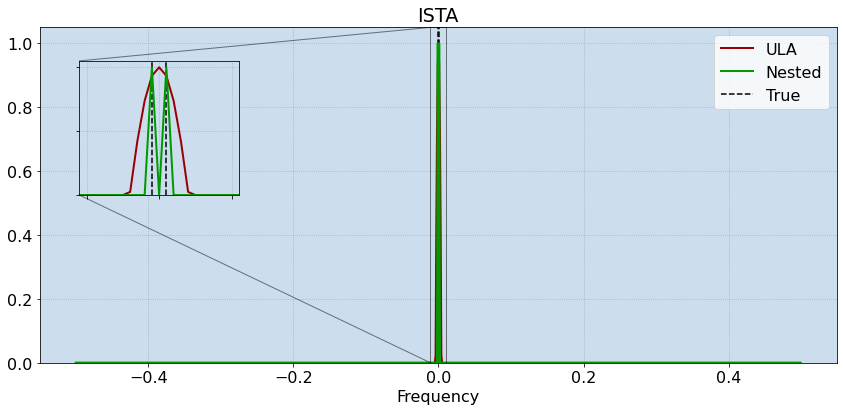

In [164]:
# Plot ULA
zoom_space = 0.01
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(fft.fftshift(fgrid), fft.fftshift(S_u), linewidth=2, color="#990000", label='ULA')
ax.plot(fft.fftshift(fgrid), fft.fftshift(S_n), linewidth=2, color='#009900', label='Nested')
y1, y2 = ax.get_ylim()
ax.vlines(th, linestyle='--', ymin=0, ymax=y2, color='k', label='True')
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('ISTA')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

# Zoomed plot
axins = ax.inset_axes([0.05, 0.5, 0.2, 0.4])
axins.plot(fft.fftshift(fgrid), fft.fftshift(S_u), linewidth=2, color='#990000', label='ULA')
axins.plot(fft.fftshift(fgrid), fft.fftshift(S_n), linewidth=2, color='#009900', label='Nested')
y1, y2 = ax.get_ylim()
axins.vlines(th, linestyle='--', ymin=y1, ymax=y2, color='k', label='True')
x1, x2 = th.min()-zoom_space, th.max()+zoom_space
axins.set_xlim(x1, x2)
axins.set_ylim(0, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.grid(color='#99AABB', linestyle=':')
axins.set_facecolor('#CCDDEE')

ax.indicate_inset_zoom(axins, edgecolor="k")
ax.legend()
plt.tight_layout()
plt.show()

In [220]:
# Create learnable alpha and lambda
a_init = torch.from_numpy(np.array(1.0)).to(device)
a = a_init.detach().clone()
a.requires_grad = True

l_init 
l_init = torch.from_numpy(np.array(50.0)).to(device)
l = l_init.detach().clone()
l.requires_grad = True

# Setup Traing Variables
Nepochs = 20
Nbatchsize = 10
Testfreq = 1
Ntraining = 100
Ntesting = 10

dataset_training = sparse_dataset(N, 2, Ntraining)
dataloader_training = DataLoader(dataset_training, 
                                 batch_size = Nbatchsize, shuffle=True)
dataset_testing = sparse_dataset(N, 2, Ntesting)
dataloader_testing = DataLoader(dataset_testing, 
                                 batch_size = 1, shuffle=False)
learning_optim = torch.optim.Adam([
                                  {'params' : [l], 'lr' : 1e-4},
                                  {'params' : [a], 'lr' : 1e-4}
])
Nbatches = int(Ntraining/Nbatchsize)
training_losslist = np.zeros(Nepochs * Nbatches)
testing_losslist = np.zeros(Nepochs * Nbatches)

In [223]:
# train LISTA for ULA
maxit = 50
x_init = torch.from_numpy(np.zeros([N, 1]).astype(float))
x0 = x_init.detach().clone()
print(x0)
A_uu = torch.from_numpy(A_u.real)
for tt in range(Nepochs):
    for kk, Xs in enumerate(dataloader_training):
        learning_idx = tt * Nbatches + kk
        for ss in range(Nbatchsize):
            xt = Xs[ss, ...].to(device)
            x0 = x_init.detach().clone().to(device)
            x_est, _ = pbnet(A_uu, a, l, x0, xt, maxit, testFlag=False)
            training_loss = torch.mean((x_est - xt)**2)
            training_loss.backward()
            
            with torch.no_grad():
                training_losslist[learning_idx] += training_loss

        learning_optim.step()
        learning_optim.zero_grad()

        print(tt, kk, training_losslist[learning_idx], end='\r')

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

KeyboardInterrupt: 